## Football Match Result Prediction - Using Neural Network 1
### Using author's configurations
<p>
<strong>
@author Avinash Rai <br/>
@lastmodified 11/03/2021
</strong>
</p>

In [2]:
import os, sys
import tensorflow as tf
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Flatten
from tensorflow.keras.optimizers import Adam

from sklearn import metrics
from utilities import getTrainTestDataset, cat_3_confusion_matrix, plot_training_history
import matplotlib.pyplot as plt

In [3]:
X_train_epl, X_test_epl, y_train_epl, y_test_epl = getTrainTestDataset("pickles\dataset-epl.pickle")
X_train_spl, X_test_spl, y_train_spl, y_test_spl = getTrainTestDataset("pickles\dataset-spl.pickle")
print(X_train_epl.shape)
print(X_train_spl.shape)
print(X_test_epl.shape)
print(X_test_spl.shape)

(1772, 29)
(1775, 29)
(874, 29)
(875, 29)


In [4]:
X_train_epl.head()

,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HTGD,ATGD,DiffPts,DiffFormPts,...,AM5,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,DiffLP
1526,-0.867168,-0.149891,-0.368570,-0.491395,-1.030352,-0.160132,-0.539587,0.291926,-0.945089,-1.174424,...,3,0,0,0,0,1,0,0,0,14
157,0.588288,2.467009,1.524303,1.000785,0.743320,2.278740,-0.783542,1.573927,-1.650598,-1.584578,...,3,0,0,0,0,0,0,0,0,7
1574,0.467000,2.162718,0.375059,1.272091,1.393667,1.921832,0.131290,1.024498,-0.560267,-0.969348,...,3,0,0,0,0,0,0,0,0,4
1850,-1.412963,-1.184480,-1.450211,-1.508791,-1.148597,-1.111887,-0.112666,0.169831,-0.047170,0.056036,...,1,0,0,0,0,0,0,0,0,6
38,-0.260728,0.397832,0.645469,-0.423569,-0.498251,0.553684,-0.844531,0.780307,-1.137501,-0.149041,...,0,0,0,0,0,0,0,0,0,15


In [5]:
X_train_spl.head()

,HTGS,ATGS,HTGC,ATGC,HTP,ATP,HTGD,ATGD,DiffPts,DiffFormPts,...,AM5,HTWinStreak3,HTWinStreak5,HTLossStreak3,HTLossStreak5,ATWinStreak3,ATWinStreak5,ATLossStreak3,ATLossStreak5,DiffLP
2020,-1.153904,-1.099911,-1.389243,-1.243118,-0.980697,-0.935257,0.067027,-0.012995,-0.048462,-0.132584,...,1,0,0,0,0,0,0,0,0,2
1143,0.694261,0.728530,1.434441,1.436632,0.923569,0.907177,-0.559609,-0.521091,0.016695,-1.185784,...,1,0,0,1,0,0,0,0,0,1
230,-0.865129,-0.528523,-0.798239,-0.262722,-0.861680,-0.578657,-0.160840,-0.295271,-0.309092,0.288696,...,0,0,0,0,0,0,0,0,0,4
1236,-0.114312,-0.299968,-1.257908,-0.720240,0.507011,-0.281490,0.978498,0.325735,0.863741,1.131256,...,3,0,0,0,0,0,0,0,0,-7
157,-0.980639,-0.757078,-0.404237,-0.197362,-1.040205,-1.113557,-0.616575,-0.577546,0.081852,0.288696,...,3,0,0,0,0,0,0,0,0,-2


## Basic Neural Network model

In [7]:
# Build model using Keras Sequential Model
input_shape = ( X_train_epl.shape[1], )
baseModel = Sequential( name="Base_Model" )
baseModel.add( Dense(41, activation='relu', input_shape=input_shape, kernel_initializer="he_normal"  ) )
baseModel.add( Dense(75, activation='relu', kernel_initializer="he_normal" ) )   
baseModel.add( Dense(3 , activation='softmax') )
baseModel.compile( optimizer=Adam(learning_rate=0.00001), 
    loss='sparse_categorical_crossentropy', metrics=['accuracy'] )
baseModel.summary()

Model: "Base_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 41)                1230      
_________________________________________________________________
dense_1 (Dense)              (None, 75)                3150      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 228       
Total params: 4,608
Trainable params: 4,608
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Train
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1 )
trainEpl = baseModel.fit( 
    X_train_epl, 
    y_train_epl, 
    epochs = 500, 
    validation_data = (X_test_epl,y_test_epl), 
    verbose = 0, 
    callbacks = [earlyStopping]
)

Epoch 00231: early stopping


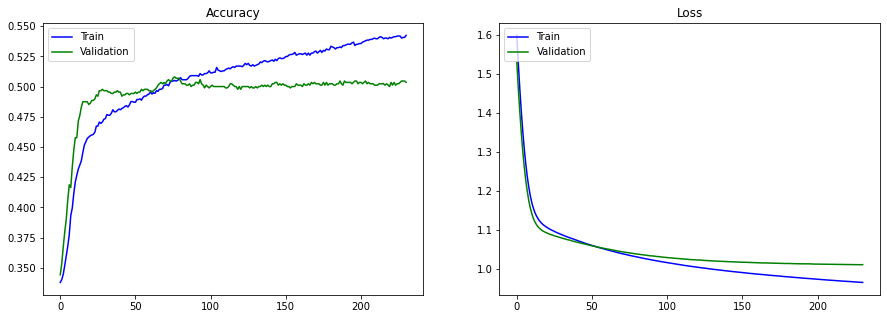

In [9]:
plot_training_history(trainEpl)

## Dynamic Neural Network

In [10]:
def buildNN( name, input_data, learning_rate, layers, dropout_rate ):
    
    input_shape = ( input_data.shape[1], )
    
    nn_model = Sequential( name=name )
    nn_model.add( Input(shape=input_shape ))
    # nn_model.add(Flatten())
    
    for layer in layers:
        nn_model.add( Dense(layer, activation = 'relu', kernel_initializer="he_normal") )
    nn_model.add( Dropout(dropout_rate) )

    # Output    
    nn_model.add( Dense(3 , activation='softmax') )
    nn_model.compile( optimizer=Adam(learning_rate=learning_rate), 
        loss='sparse_categorical_crossentropy', metrics=['accuracy'] )
    nn_model.summary()
    
    return nn_model

### EPL

In [11]:
# EPL[1e-05, ‘41–75–3’, 0.5, 16, 2.8191776275634766, 0.6168224215507507]
epl_best_model = buildNN( "epl_roland-shun-41-75-3", X_train_epl, 0.00001, [41,75], 0.5 )

Model: "epl_roland-shun-41-75-3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 41)                1230      
_________________________________________________________________
dense_4 (Dense)              (None, 75)                3150      
_________________________________________________________________
dropout (Dropout)            (None, 75)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 228       
Total params: 4,608
Trainable params: 4,608
Non-trainable params: 0
_________________________________________________________________


In [12]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1 )
training = epl_best_model.fit( 
    X_train_epl, 
    y_train_epl, 
    batch_size = 16, 
    epochs = 500,
    validation_data = (X_test_epl,y_test_epl),
    callbacks = [ earlyStopping ],
    verbose = 0
)

Epoch 00019: early stopping


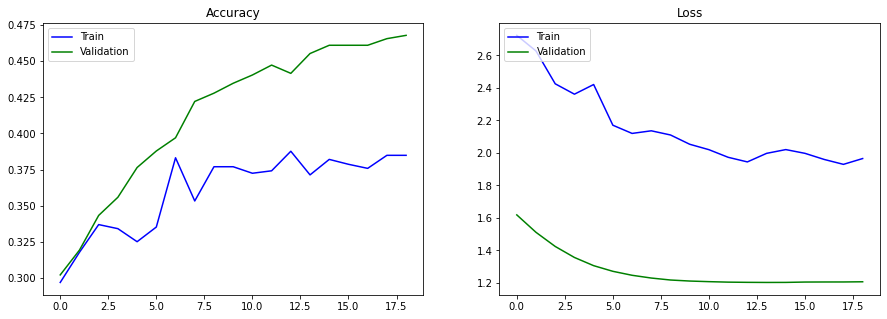

In [13]:
plot_training_history(training)

In [14]:
# Save model
save_path = "saved_models\\" + epl_best_model.name + ".h5"
epl_best_model.save( save_path )

### La Liga

In [15]:
# La Liga[1e-05, ‘41–10–10–10–3’, 0, 32, 0.9817492961883545, 0.5420560836791992]
spl_best_model = buildNN( "spl_roland-shun-41-10-10-10", X_train_spl, 0.00001, [41,10,10,10], 0 )

Model: "spl_roland-shun-41-10-10-10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 41)                1230      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                420       
_________________________________________________________________
dense_8 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_9 (Dense)              (None, 10)                110       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 33        
Total params: 1,903
Trainable params: 1,903
Non-trainable params: 0
_____________________________________

In [16]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1 )
spl_training = spl_best_model.fit( 
    X_train_spl, 
    y_train_spl,
    batch_size = 32,
    epochs = 500,
    validation_data = (X_test_spl, y_test_spl),
    callbacks = [ earlyStopping ],
    verbose = 0
)

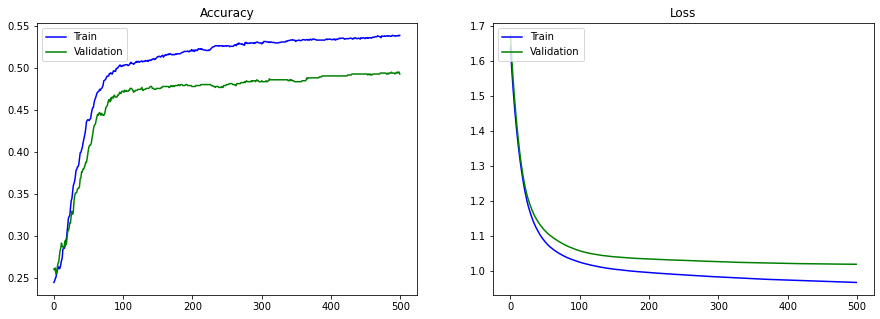

In [17]:
plot_training_history(spl_training)

In [18]:
# Save model
save_path = "saved_models\\" + spl_best_model.name + ".h5"
spl_best_model.save( save_path )